# CESM-LE analysis
### Looks and changes in Fire risk (accumulated Nesterov Index)
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily TBOT, RH, & precip
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait
import FWI_Wang2015 as fwi  # Jackie's python script

%matplotlib inline

### run this cell to check if you have LENS2 read access:

In [2]:
samplefile = (
    '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'
    + 'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc'
)
cmd = 'stat ' + samplefile
if os.system(cmd) != 0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [3]:
# For use on Casper: ONLY RUN THIS CELL ONCE
# note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18)
#    to allow dask to allocate more memory to each worker"
ncores = 10
nmem = str(int(400 * ncores / ncores)) + 'GB'
from dask.distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(
    cores=ncores,
    processes=ncores,
    memory=nmem,
    #project='P93300641',
    walltime='1:00:00',
    extra=["--lifetime", "55m", "--lifetime-stagger", "4m"],
)
# cluster.scale(ncores)
cluster.adapt(minimum_jobs=7, maximum_jobs=7)  # change to 9 w/ 50 ens members
client = Client(cluster)

In [4]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
cluster

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

In [5]:
#cluster.close()
#client.restart()
#client

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [6]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [7]:
def file_dict(model,mem,field,component,hist=True,freq='monthly'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]
    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+ \
                  component+'/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        ATM     = '/atm/proc/tseries/'
        LND     = '/lnd/proc/tseries/'
        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            if component == 'lnd': tape    = '.h5.'
            if component == 'atm': tape    = '.h1.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        if component == 'lnd':
            thisdir = topdir+runtype+mm+LND+freq
        if component == 'atm':
            thisdir = topdir+runtype+mm+ATM+freq

        #find all the relevant files
        files = glob.glob(thisdir+'*'+tape+field+'.*')

    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths

In [8]:
def get_file(model,mem,field,year,component,freq='monthly'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,component,freq)

    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [9]:
def all_files(model,ens,field,firstyear,lastyear, component,\
              freq='monthly'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,component,hist,freq)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [10]:
def preprocess(ds):
    variables = {"RAIN", "SNOW", "TREFHT", "RHREFHT", "WSPDSRFAV", "TREFHTMX", "PPT"}
    x = list(set(ds.data_vars).difference(variables))
    for v in x:
        ds = ds.set_coords(v)
        ds[v].load()
    return ds

In [11]:
def get_data(model,ens,fields,firstyear,lastyear,component,freq, \
             chunks={'time':1000}):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset

    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,component,freq)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']
        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,combine='nested',
                                    parallel=True,
                                    concat_dim=dims,
                                    chunks=chunks,
                                    preprocess=preprocess)
            tmp = preprocess(tmp)
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,combine='nested',
                                       parallel=True,
                                       concat_dim=['time'],
                                       chunks=chunks,
                                       preprocess=preprocess)
                d0 = preprocess(d0)
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    tmp = preprocess(tmp)
    
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [12]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

In [13]:
def month_wts(nyears):
    days_pm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    return xr.DataArray(np.tile(days_pm, nyears), dims='time')

------------
# Start editing here:

### Actually read the data

In [14]:
%%time

lnd_vars = ['RAIN', 'SNOW']
model = 'CESM2'
firstyear = 1850
lastyear  = 2100
freq      = 'daily'

component = 'lnd'
ens = 10+np.arange(5)
nens = len(ens)
ds = get_data(model,ens,lnd_vars,firstyear,lastyear,
              component,freq).persist()
_ = wait(ds)
print('lnd read in')

atm_vars = ['TREFHT', 'RHREFHT'] 
component = 'atm'
ds_atm = get_data(model,ens,atm_vars,firstyear,lastyear,
                  component,freq).persist()
_ = wait(ds_atm)
print('atm read in')

lnd read in
atm read in
CPU times: user 52.4 s, sys: 3.49 s, total: 55.9 s
Wall time: 1min 28s


- 5 ensembles = 405 GB data [with this smaller list]!
- compute works with 60 workers in ~2 minutes.

405.302161872

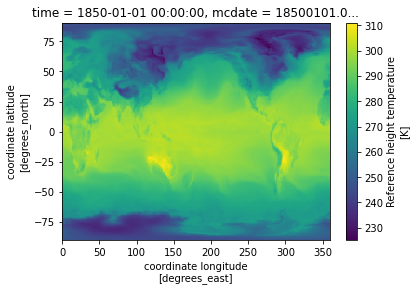

In [15]:
# force coordinate variables to match
ds_atm['lat'] = ds['lat']
ds_atm['lon'] = ds['lon']

for i in range(len(atm_vars)):
    ds[atm_vars[i]] = ds_atm[atm_vars[i]]

ds = client.persist(ds)
_ = wait(ds)
del ds_atm

ds[atm_vars[0]].isel(ens=0, time=0).plot();
ds.nbytes/1e9 #GB

### Convert units as needed

CPU times: user 7.99 s, sys: 430 ms, total: 8.42 s
Wall time: 29.1 s


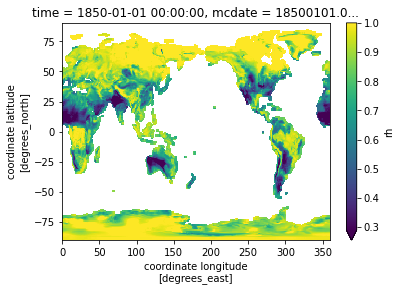

In [16]:
%%time

# sum rain + snow for precip.
s2d = 3600 * 24  # convert from sec to day
ds['PPT'] = (ds['RAIN'] + ds['SNOW']) * s2d
ds.PPT.attrs['units'] = 'mm/d'
ds.PPT.attrs['long_name'] = 'Total Precip.'

ds['TREFHT'] = ds['TREFHT'] - 273.15  # convert to degC
ds['TREFHT'].attrs['units'] = 'degC'

# set max RH, used fire weather calculation...
ds['RHREFHT'] = ds.RHREFHT.where(ds.RHREFHT < 100, 100)
ds['RHREFHT'] = ds['RHREFHT'] / 100  # convert to fraction

ds = ds.rename({'TREFHT':'temp', 'RHREFHT':'rh'})
# mask out missing values (again) & compute data
ds = ds.where(ds['PPT'].max(['time', 'ens']) > 0.0)  
ds = client.persist(ds)
_ = wait(ds)

ds['rh'].isel(time=0, ens=0).plot(robust=True) ;

In [17]:
del ds['RAIN']
del ds['SNOW']
ds

,Array,Chunk
Bytes,101.32 GB,221.18 MB
Shape,"(5, 91616, 192, 288)","(1, 1000, 192, 288)"
Count,505 Tasks,505 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,101.32 GB,221.18 MB
Shape,"(5, 91616, 192, 288)","(1, 1000, 192, 288)"
Count,505 Tasks,505 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


--------------
## Calculate Nesterov Fire Danger Index
- acc_NI is the accumulated Nesterov fire danger index, which resets w/ daily precip > 3 mm 
- d_NI is the daily Nesterov fire danger index, calculated from temp, precip & RH
- from https://github.com/NGEET/fates/blob/master/fire/SFMainMod.F90

  - temp  = TREFHT (in C)
  - ppt   = PPT*sec_per_day (mm)
  - rh    = RHREFHT (fraction)
   
Nesterov Fire danger Index code in FATES: https://github.com/NGEET/fates/blob/8827a6ea77f0e4f5d8408ddd7eeaa776bb3bba8a/fire/SFMainMod.F90#L116-L162


CPU times: user 679 ms, sys: 33.4 ms, total: 712 ms
Wall time: 2.06 s


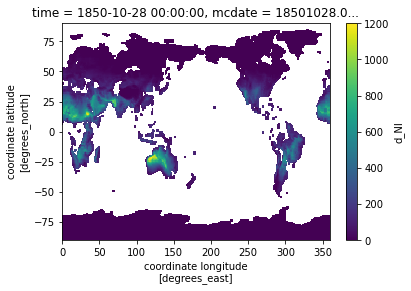

In [18]:
%%time
# these are the calculations that take forever!
# maybe it's not worth loading thse intermediate calculations into memory?

# Fates_fire constants
# Nesterov from EQ 5 Thonicke et al 2010:
fdi_a = 17.62
fdi_b = 243.12

yipsolon = (fdi_a * ds.temp) / (fdi_b + ds.temp) + np.log(ds.rh)

# Standard met. formula
dewpoint = (fdi_b * yipsolon) / (fdi_a - yipsolon)

# follows Nesterov 1968.  Equation 5. Thonicke et al. 2010.
ds['d_NI'] = (ds.temp - dewpoint) * ds.temp  # .compute(skipna=True)

# don't allow negative values
ds['d_NI'] = ds['d_NI'].where(ds['d_NI'] > 0, 0)

# Reset when daily precip > 3 mm/day
ds['d_NI'] = ds['d_NI'].where(ds.PPT < 3, np.nan)  # .compute(skipna=True)
ds['d_NI'].isel(ens=0, time=300).plot() ;

### Accumulate Nesterov index over the fire season
####  Reset when daily precip > 3 mm/day (set d_NI to nan) 

In [19]:
def running_sum_np(data):
    v = pd.Series(data.copy())
    cumsum = v.cumsum().fillna(method='pad')
    reset = -cumsum[v.isnull()].diff().fillna(cumsum)
    result = v.where(v.notnull(), reset).cumsum()
    return result.values

In [20]:
#%%time
#temp2 = running_sum_np(tempIn.isel(ens=0))
#plt.plot(temp2) ;
#del acc_NI

### Now try over full grid

~~Must load into memory first~~ 


In [21]:
# use apply_ufunc to broadcast running_sum_1d function globally
# Make sure the input dataset isn't chunked along the core `time` dimension
input_ds = ds.d_NI.chunk({'time': -1, 'lat':50,'lon':50})
input_ds = input_ds.transpose('ens','lat','lon','time')

acc_NI = xr.apply_ufunc(
    running_sum_np,
    input_ds,
    input_core_dims=[['time']],
    output_core_dims=[["time"]],
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=[ds.d_NI.dtype],
)

print('compute in next cell')

compute in next cell


In [22]:
%%time
acc_NI = client.persist(acc_NI, retries=3)
_ = wait(acc_NI)

# get back orig. chunk sizes
acc_NI = acc_NI.chunk({'time': 1000, 'lat':50,'lon':50})

CPU times: user 17 s, sys: 970 ms, total: 18 s
Wall time: 1min 39s


In [25]:
print(acc_NI)

<xarray.DataArray 'd_NI' (ens: 5, lat: 192, lon: 288, time: 91616)>
dask.array<rechunk-merge, shape=(5, 192, 288, 91616), dtype=float32, chunksize=(1, 50, 50, 1000), chunktype=numpy.ndarray>
Coordinates: (12/34)
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    area          (lat, lon) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    landfrac      (lat, lon) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    landmask      (lat, lon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    pftmask       (lat, lon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    ...            ...
    ch4vmr        (time) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    n2ovmr        (time) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    f12vmr        (time) fl

### Write out accumulated NI to disk?

In [ ]:
%%time
acc_NI = acc_NI.to_dataset(name='acc_NI')
acc_NI['acc_NI'].attrs['long_name'] = 'accum. Nesterov Index'
fout = '/glade/scratch/wwieder/FWI/'

i = 1
#for i in range(nens):
acc_NI.isel(ens=i).squeeze().to_netcdf(fout+'acc_NI_'+str(ens[i])+'.nc')
print('wrote '+fout+'acc_NI_'+str(ens[i])+'.nc')

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/conventions.py:207: SerializationWarning: variable date_written has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  SerializationWarning,
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/conventions.py:207: SerializationWarning: variable time_written has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  SerializationWarning,


Can the step above be done more efficiently? 

Quick look at data below...

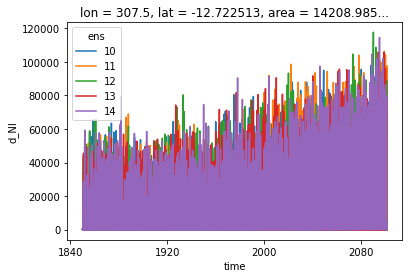

In [31]:
# faster to select grid here
plat, plon, site = -13 , 307.5, 'Amazon'
#plat, plon, site = 66.4, 209  , 'Alaska'
#plat, plon, site = 39  , 253  , 'Crested Butte'
# 40, 270
temp = acc_NI.sel(lat=plat, lon=plon, method='nearest')
temp.plot(hue='ens') ;

## NI Fire Risk classification
* 0-300 minimal danger
* to 1000 moderate
* to 4000 high
* above 4000 extreme

In [32]:
%%time
# Ensemble mean of days / year with extreme fire risk
exCount = (
    acc_NI.where(acc_NI > 4000)
    .resample(time='Y', skipna=True)
    .count(dim='time')
    .mean(dim='ens')
    .compute(skipna=True)
)
print('finished exCount mean')

exCountstd = (
    acc_NI.where(acc_NI > 4000)
    .resample(time='Y', skipna=True)
    .count(dim='time')
    .std(dim='ens')
    .compute(skipna=True)
)

finished exCount
CPU times: user 23.9 s, sys: 853 ms, total: 24.7 s
Wall time: 30 s


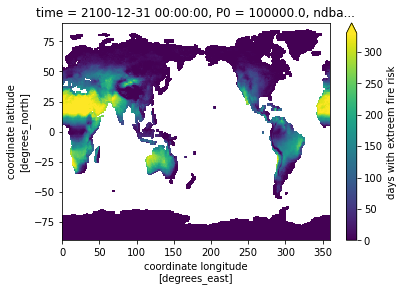

In [34]:
exCount.where(ds['PPT'].max(['time', 'ens']) > 0.0).isel(time=-1).plot(
    robust=True, cbar_kwargs={"label": "days with extreem fire risk"}
);

## Change days with in extreme fire risk 

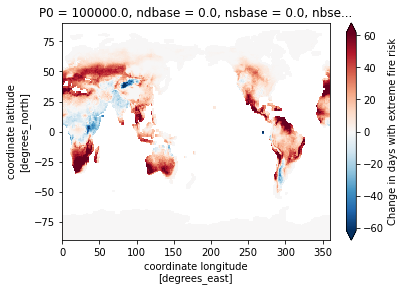

In [35]:
(exCount.isel(time=slice(-10,None)).mean('time') - 
 exCount.isel(time=slice(  0, 10 )).mean('time')) \
  .where(ds['PPT'].max(['time', 'ens']) > 0) \
  .plot(robust=True, 
        cbar_kwargs={"label": "Change in days with extreme fire risk"}) ;

Text(0.5, 1.0, '')

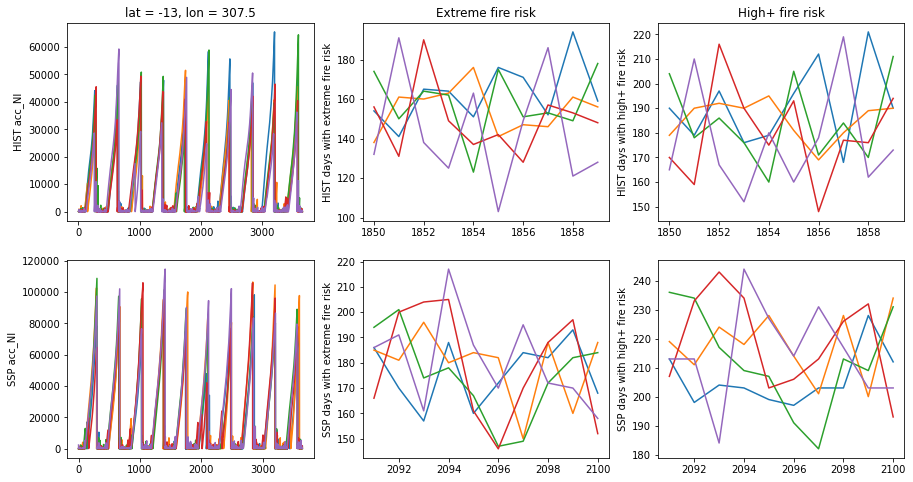

In [36]:
plt.figure(figsize=[15, 8])
plt.subplot(2, 3, 1)
plt.plot(temp.isel(time=slice(0,3650)) \
             .transpose('time', 'ens'))
plt.title('lat = ' + str(plat) + ', lon = ' + str(plon))
plt.ylabel('HIST acc_NI')
plt.xlabel('')

plt.subplot(2, 3, 2)
exCount = temp.where(temp > 4000) \
              .isel(time=slice(0,3650)) \
              .groupby('time.year').count(dim='time')
exCount.plot(hue='ens', add_legend=False)
plt.ylabel('HIST days with extreme fire risk')
plt.xlabel('')
plt.title('Extreme fire risk')

plt.subplot(2, 3, 3)
hiCount = temp.where(temp > 1000) \
              .isel(time=slice(0,3650)) \
              .groupby('time.year').count(dim='time')
hiCount.plot(hue='ens', add_legend=False)
plt.ylabel('HIST days with high+ fire risk')
plt.xlabel('')
plt.title('High+ fire risk')

plt.subplot(2, 3, 4)
plt.plot(temp.isel(time=slice(-3650,None)) \
             .transpose('time', 'ens'))
plt.title('')
plt.ylabel('SSP acc_NI')
plt.xlabel('')

plt.subplot(2, 3, 5)
exCount = temp.where(temp > 4000) \
              .isel(time=slice(-3650,None)) \
              .groupby('time.year').count(dim='time')
exCount.plot(hue='ens', add_legend=False)
plt.ylabel('SSP days with extreme fire risk')
plt.xlabel('')
plt.title('')

plt.subplot(2, 3, 6)
hiCount = temp.where(temp > 1000) \
              .isel(time=slice(-3650,None)) \
              .groupby('time.year').count(dim='time')
hiCount.plot(hue='ens', add_legend=False)
plt.ylabel('SSP days with high+ fire risk')
plt.xlabel('')
plt.title('')

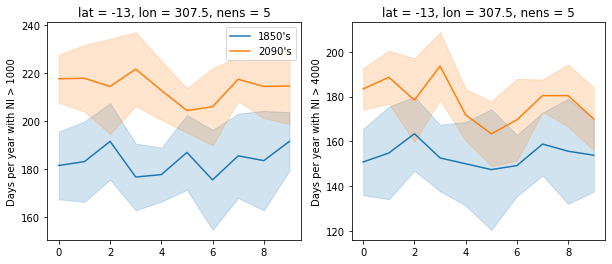

In [37]:
plt.figure(figsize=[10, 4])
minRisk = [1000, 4000]
for i in range(2):
    exCount_HIST = (
        temp.where(temp > minRisk[i]) \
            .isel(time=slice(0,3650)) \
            .groupby('time.year').count(dim='time').mean(dim='ens')
    )
    exCount_HISTsd = (
        temp.where(temp > minRisk[i]) \
            .isel(time=slice(0,3650)) \
            .groupby('time.year').count(dim='time').std(dim='ens')
    )
    exCount_SSP = (
        temp.where(temp > minRisk[i]) \
               .isel(time=slice(-3650,None)) \
               .groupby('time.year').count(dim='time').mean(dim='ens')
    )
    exCount_SSPsd = (
        temp.where(temp > minRisk[i]) \
               .isel(time=slice(-3650,None)) \
               .groupby('time.year').count(dim='time').std(dim='ens')
    )
    x1 = range(len(exCount_HIST.year))
    x2 = range(len(exCount_SSP.year))
    plt.subplot(1, 2, (i + 1))
    plt.plot(x1, exCount_HIST)
    plt.plot(x2, exCount_SSP)
    plt.fill_between(
        x1,
        exCount_HIST - exCount_HISTsd,
        exCount_HIST + exCount_HISTsd,
        alpha=0.2,
        color='tab:blue',
    )
    plt.fill_between(
        x2, exCount_SSP - exCount_SSPsd, exCount_SSP + exCount_SSPsd, alpha=0.2, color='tab:orange'
    )
    plt.title('lat = ' + str(plat) + ', lon = ' + str(plon) + ', nens = ' + str(nens))
    plt.ylabel('Days per year with NI > ' + str(minRisk[i]))
    if i == 0:
        plt.legend(["1850's", "2090's"])
# plt.plot(exCount_SSP)

### Accumulated Nesterov fire danger index shows 
- increases in the number of days per year with high or extreme fire danger in 2100, relative to 2000, 
- better to just plot the whole time seires...
- check for statistical significance

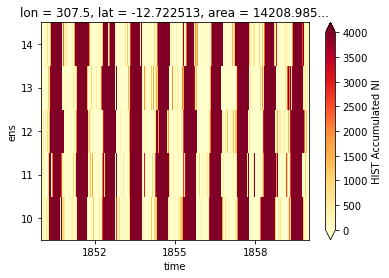

In [40]:
temp.isel(time=slice(0,3650)).plot(
    robust=True, cmap='YlOrRd', vmax=4000, vmin=0, 
    cbar_kwargs={"label": "HIST Accumulated NI"}
) ;

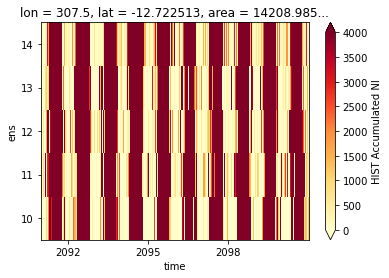

In [41]:
temp.isel(time=slice(-3650,None)).plot(
    robust=True, cmap='YlOrRd', vmax=4000, vmin=0, 
    cbar_kwargs={"label": "HIST Accumulated NI"}
);

- Maybe better illustrates seaonal cycle of fire risk? 
- Appears to have greater variability by 2100!

In [2]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2021-02-24

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.20.0

Git hash: f2c26d9d6bf7afdb0315409c0a55dc546a7dc2b7

Git repo: git@github.com:andersy005/cesm-lens.git

Git branch: optimizations

pandas    : 1.2.2
numpy     : 1.20.1
numba     : 0.52.0
matplotlib: 3.3.4
dask      : 2021.2.0
xarray    : 0.16.2
cftime    : 1.4.1
scipy     : 1.6.0

